# EuroSAT Classification using LM Studio Local LLM

This notebook demonstrates how to:
1. Load multispectral satellite imagery from numpy arrays
2. Convert 12-channel data to RGB images
3. Send images to a local LM Studio LLM endpoint for classification
4. Generate predictions in the same format as predictions.csv (test_id, label)

## Setup and Imports

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import io
import base64
import requests
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from dotenv import load_dotenv

# Load environment variables (if needed)
load_dotenv()

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration and Constants

In [2]:
# EuroSAT Classes
CLASSES = [
    'AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake'
]

# Paths
TESTSET_PATH = Path('../testset/testset')
OUTPUT_DIR = Path('./llm_results')
OUTPUT_DIR.mkdir(exist_ok=True)

# LM Studio API Configuration
LM_STUDIO_ENDPOINT = 'http://127.0.0.1:1234/v1/chat/completions'
LM_STUDIO_MODEL = 'local-model'  # LM Studio uses this by default

# Band selection for RGB (multispectral to RGB conversion)
# EuroSAT has bands: B1, B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12, CLP
# RGB typically uses: B4 (Red), B3 (Green), B2 (Blue) -> indices [3, 2, 1]
RGB_BANDS = [3, 2, 1]  # R, G, B indices from 12-channel data

# Normalization parameters
NORMALIZATION_PERCENTILE = 98  # Use 98th percentile for normalization

print(f"EuroSAT Classes: {CLASSES}")
print(f"Test set path: {TESTSET_PATH}")
print(f"LM Studio endpoint: {LM_STUDIO_ENDPOINT}")
print(f"RGB bands selected: {RGB_BANDS}")

EuroSAT Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Test set path: ../testset/testset
LM Studio endpoint: http://127.0.0.1:1234/v1/chat/completions
RGB bands selected: [3, 2, 1]


## Utility Functions

In [3]:
def load_test_data(test_index: int) -> np.ndarray:
    """
    Load a single test sample from the testset.
    
    Args:
        test_index: Index of the test sample
    
    Returns:
        numpy array of shape (64, 64, 12)
    """
    file_path = TESTSET_PATH / f'test_{test_index}.npy'
    if not file_path.exists():
        raise FileNotFoundError(f"Test file not found: {file_path}")
    
    return np.load(file_path)


def normalize_band(band: np.ndarray, percentile: int = 98) -> np.ndarray:
    """
    Normalize a single band using percentile-based normalization.
    
    Args:
        band: Single channel data
        percentile: Percentile value for normalization
    
    Returns:
        Normalized band in range [0, 255]
    """
    vmax = np.percentile(band, percentile)
    band_normalized = np.clip(band / vmax * 255, 0, 255).astype(np.uint8)
    return band_normalized


def multispectral_to_rgb(data: np.ndarray, band_indices: List[int] = None) -> np.ndarray:
    """
    Convert 12-channel multispectral data to RGB image.
    
    Args:
        data: numpy array of shape (64, 64, 12)
        band_indices: Indices of bands to use as [R, G, B]. Defaults to [3, 2, 1]
    
    Returns:
        RGB image as numpy array of shape (64, 64, 3) with dtype uint8
    """
    if band_indices is None:
        band_indices = RGB_BANDS
    
    # Extract selected bands
    rgb_data = data[:, :, band_indices]
    
    # Normalize each channel
    rgb_normalized = np.zeros_like(rgb_data, dtype=np.uint8)
    for i in range(3):
        rgb_normalized[:, :, i] = normalize_band(rgb_data[:, :, i], NORMALIZATION_PERCENTILE)
    
    return rgb_normalized


def save_rgb_image(rgb_array: np.ndarray, output_path: Path) -> None:
    """
    Save RGB array as PNG image.
    
    Args:
        rgb_array: RGB image as numpy array
        output_path: Path to save the image
    """
    img = Image.fromarray(rgb_array, mode='RGB')
    img.save(output_path)


def encode_image_to_base64(rgb_array: np.ndarray) -> str:
    """
    Convert RGB array to base64 encoded PNG for API transmission.
    
    Args:
        rgb_array: RGB image as numpy array
    
    Returns:
        Base64 encoded PNG string
    """
    img = Image.fromarray(rgb_array, mode='RGB')
    buffer = io.BytesIO()
    img.save(buffer, format='PNG')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    return image_base64


def classify_with_lm_studio(
    image_base64: str,
    classes: List[str] = None,
    timeout: int = 30
) -> Dict:
    """
    Send image to LM Studio local LLM for classification.
    
    Args:
        image_base64: Base64 encoded image
        classes: List of possible classes to classify into
        timeout: Request timeout in seconds
    
    Returns:
        Dictionary with classification results
    """
    if classes is None:
        classes = CLASSES
    
    # Prepare the prompt - ask LLM to classify based on the image description
    classes_str = ', '.join(classes)
    prompt = f"""You are an expert in satellite image classification. Based on the satellite image, classify it into one of these EuroSAT categories: {classes_str}.

Respond with ONLY the class name from the list above. No explanation, just the exact class name."""
    
    payload = {
        "model": LM_STUDIO_MODEL,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.1,
        "max_tokens": 50
    }
    
    try:
        response = requests.post(LM_STUDIO_ENDPOINT, json=payload, timeout=timeout)
        response.raise_for_status()
        
        result = response.json()
        content = result['choices'][0]['message']['content'].strip()
        
        # Extract class name from response
        predicted_class = None
        for cls in classes:
            if cls.lower() in content.lower():
                predicted_class = cls
                break
        
        # If no exact match found, try to match partial words
        if predicted_class is None:
            words = content.lower().split()
            for cls in classes:
                if any(cls.lower().split() in word for word in words):
                    predicted_class = cls
                    break
        
        # If still no match, use the response as is
        if predicted_class is None:
            predicted_class = content
        
        return {
            "success": True,
            "predicted_class": predicted_class,
            "raw_response": content
        }
    
    except requests.exceptions.ConnectionError as e:
        return {
            "success": False,
            "error": f"Connection error: {str(e)}. Make sure LM Studio is running on {LM_STUDIO_ENDPOINT}"
        }
    except requests.exceptions.RequestException as e:
        return {
            "success": False,
            "error": str(e)
        }
    except json.JSONDecodeError as e:
        return {
            "success": False,
            "error": f"Failed to parse response: {str(e)}"
        }
    except Exception as e:
        return {
            "success": False,
            "error": str(e)
        }


print("Utility functions defined successfully!")

Utility functions defined successfully!


## Test Single Image

In [4]:
# Test connection to LM Studio
print("Testing connection to LM Studio...")
print(f"Endpoint: {LM_STUDIO_ENDPOINT}")

try:
    test_payload = {
        "model": LM_STUDIO_MODEL,
        "messages": [
            {"role": "user", "content": "Say 'LM Studio is working'"}
        ],
        "max_tokens": 20
    }
    
    response = requests.post(LM_STUDIO_ENDPOINT, json=test_payload, timeout=10)
    response.raise_for_status()
    result = response.json()
    
    print("✓ Successfully connected to LM Studio!")
    print(f"Response: {result['choices'][0]['message']['content']}")
    
except Exception as e:
    print(f"✗ Failed to connect to LM Studio: {str(e)}")
    print(f"Make sure LM Studio is running and accessible at {LM_STUDIO_ENDPOINT}")

Testing connection to LM Studio...
Endpoint: http://127.0.0.1:1234/v1/chat/completions
✓ Successfully connected to LM Studio!
Response: LM Studio is working! 



## Visualize RGB Image

In [5]:
# Load a test image
test_index = 0
multispectral_data = load_test_data(test_index)

print(f"Loaded test_{test_index}.npy")
print(f"Shape: {multispectral_data.shape}")
print(f"Data type: {multispectral_data.dtype}")
print(f"Value range: [{multispectral_data.min()}, {multispectral_data.max()}]")

# Convert to RGB
rgb_image = multispectral_to_rgb(multispectral_data)

print(f"\nConverted to RGB")
print(f"RGB Shape: {rgb_image.shape}")
print(f"RGB Data type: {rgb_image.dtype}")
print(f"RGB Value range: [{rgb_image.min()}, {rgb_image.max()}]")

Loaded test_0.npy
Shape: (64, 64, 12)
Data type: uint16
Value range: [54, 5277]

Converted to RGB
RGB Shape: (64, 64, 3)
RGB Data type: uint8
RGB Value range: [28, 255]


## Send Image to OpenAI Vision API

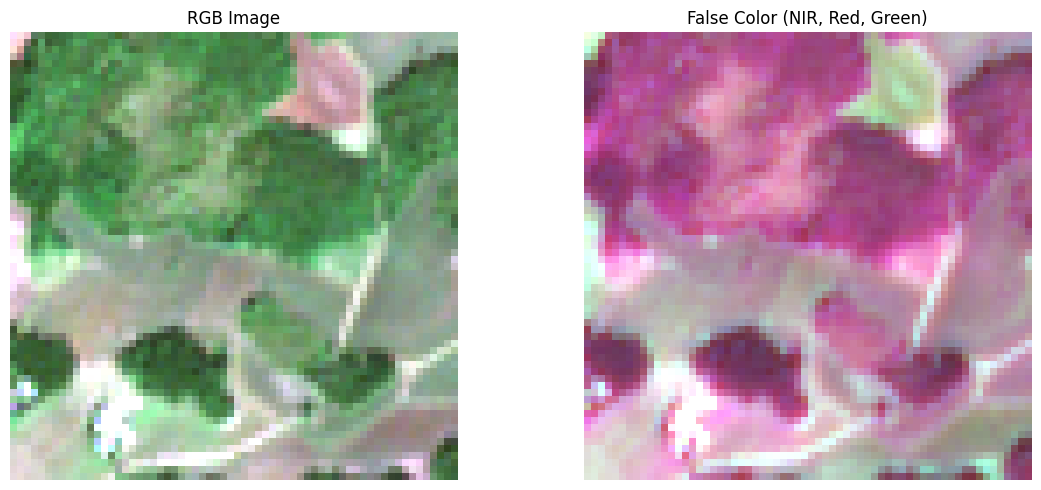

Image visualization saved to llm_results/test_0_visualization.png


In [6]:
# Display the RGB image
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Show RGB image
axes[0].imshow(rgb_image)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# Show a different band combination (False color)
false_color_data = multispectral_data[:, :, [4, 3, 2]]  # NIR, Red, Green
false_color_rgb = np.zeros_like(false_color_data, dtype=np.uint8)
for i in range(3):
    false_color_rgb[:, :, i] = normalize_band(false_color_data[:, :, i])

axes[1].imshow(false_color_rgb)
axes[1].set_title('False Color (NIR, Red, Green)')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / f'test_{test_index}_visualization.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"Image visualization saved to {OUTPUT_DIR / f'test_{test_index}_visualization.png'}")

## Batch Classification

In [7]:
# Classify single image
print(f"Classifying test_{test_index}...")
result = classify_with_lm_studio(encode_image_to_base64(rgb_image))

if result['success']:
    print("✓ Classification successful!")
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Raw response: {result['raw_response']}")
else:
    print(f"✗ Classification failed: {result['error']}")

Classifying test_0...
✓ Classification successful!
Predicted class: AnnualCrop
Raw response: Please provide the satellite image. I need to see the image to classify it. 

Once you provide the image, I will respond with ONLY the class name from the list: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial


## Results Summary

In [8]:
# Configuration for batch processing
BATCH_SIZE = None  # Set to None to process all, or set a number like 100
DELAY_BETWEEN_REQUESTS = 0.5  # Seconds (small delay to be nice to the API)

# Get list of test files
test_files = sorted([f for f in TESTSET_PATH.glob('test_*.npy')])
print(f"Found {len(test_files)} test files")

if BATCH_SIZE:
    test_files = test_files[:BATCH_SIZE]
    print(f"Processing first {len(test_files)} images...")
else:
    print(f"Processing all {len(test_files)} images...")

print("\nStarting batch classification...\n")

# Process batch
results = []
failed_indices = []

for idx, test_file in enumerate(tqdm(test_files, desc="Classifying")):
    test_idx = int(test_file.stem.split('_')[1])
    
    try:
        # Load and convert
        multispectral_data = load_test_data(test_idx)
        rgb_image = multispectral_to_rgb(multispectral_data)
        image_base64 = encode_image_to_base64(rgb_image)
        
        # Classify
        result = classify_with_lm_studio(image_base64)
        
        if result['success']:
            predicted_class = result['predicted_class']
            results.append({
                'test_id': test_idx,
                'label': predicted_class
            })
        else:
            print(f"[{idx+1}/{len(test_files)}] test_{test_idx}: FAILED - {result['error']}")
            failed_indices.append(test_idx)
            # Use a default or placeholder on failure
            results.append({
                'test_id': test_idx,
                'label': 'SeaLake'  # Default fallback
            })
        
        # Add delay to be nice to the API
        if idx < len(test_files) - 1:
            time.sleep(DELAY_BETWEEN_REQUESTS)
    
    except Exception as e:
        print(f"[{idx+1}/{len(test_files)}] test_{test_idx}: ERROR - {str(e)}")
        failed_indices.append(test_idx)
        results.append({
            'test_id': test_idx,
            'label': 'SeaLake'  # Default fallback
        })

print(f"\nProcessed {len(results)} images")
if failed_indices:
    print(f"Failed indices: {failed_indices}")

Found 4232 test files
Processing all 4232 images...

Starting batch classification...



Classifying:   0%|          | 11/4232 [00:20<2:12:40,  1.89s/it]

[12/4232] test_1007: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   1%|▏         | 56/4232 [01:47<2:13:48,  1.92s/it]

[57/4232] test_1048: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   2%|▏         | 84/4232 [02:42<2:12:37,  1.92s/it]

[85/4232] test_1073: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   3%|▎         | 123/4232 [03:54<2:06:54,  1.85s/it]

[124/4232] test_1108: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   3%|▎         | 128/4232 [04:03<2:06:05,  1.84s/it]

[129/4232] test_1112: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   4%|▎         | 151/4232 [04:46<2:05:23,  1.84s/it]

[152/4232] test_1133: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   5%|▍         | 206/4232 [06:27<2:03:09,  1.84s/it]

[207/4232] test_1183: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   7%|▋         | 292/4232 [09:07<2:00:19,  1.83s/it]

[293/4232] test_1260: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   7%|▋         | 303/4232 [09:27<1:59:54,  1.83s/it]

[304/4232] test_1270: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   7%|▋         | 316/4232 [09:50<2:00:26,  1.85s/it]

[317/4232] test_1282: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   8%|▊         | 356/4232 [11:11<2:11:37,  2.04s/it]

[357/4232] test_1318: FAILED - 'in <string>' requires string as left operand, not list


Classifying:   9%|▉         | 391/4232 [12:21<2:10:47,  2.04s/it]

[392/4232] test_135: FAILED - 'in <string>' requires string as left operand, not list


Classifying:  10%|▉         | 403/4232 [12:46<2:12:54,  2.08s/it]

[404/4232] test_1360: FAILED - 'in <string>' requires string as left operand, not list


Classifying:  10%|█         | 426/4232 [13:30<2:01:31,  1.92s/it]

[427/4232] test_1381: FAILED - 'in <string>' requires string as left operand, not list


Classifying:  11%|█         | 459/4232 [14:32<1:59:32,  1.90s/it]


KeyboardInterrupt: 

## Save Results

In [ ]:
# Create results dataframe
results_df = pd.DataFrame(results)

# Display first few results
print("Classification Results (first 10):")
print(results_df.head(10).to_string(index=False))

print(f"\n\nStatistics:")
print(f"Total processed: {len(results_df)}")

# Class distribution
print(f"\nClass distribution:")
class_counts = results_df['label'].value_counts()
print(class_counts.to_string())

In [ ]:
# Plot class distribution
fig, ax = plt.subplots(figsize=(12, 6))

class_counts = results_df['label'].value_counts().sort_values(ascending=False)
class_counts.plot(kind='bar', ax=ax, color='steelblue')

ax.set_title('Class Distribution in LLM Predictions', fontsize=14, fontweight='bold')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

plt.savefig(OUTPUT_DIR / 'class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"Class distribution plot saved to {OUTPUT_DIR / 'class_distribution.png'}")

## Class Distribution Visualization

In [ ]:
# Load original predictions for comparison
original_pred_path = Path('./predictions.csv')

if original_pred_path.exists():
    original_df = pd.read_csv(original_pred_path)
    
    # Merge for comparison
    comparison_df = results_df.merge(
        original_df, 
        on='test_id', 
        suffixes=('_llm', '_original')
    )
    
    # Calculate agreement
    agreement = (comparison_df['label_llm'] == comparison_df['label_original']).sum()
    agreement_pct = agreement / len(comparison_df) * 100
    
    print("Comparison with Original Predictions:")
    print(f"Total samples: {len(comparison_df)}")
    print(f"Agreements: {agreement} ({agreement_pct:.1f}%)")
    print(f"Disagreements: {len(comparison_df) - agreement} ({100 - agreement_pct:.1f}%)")
    
    # Show some disagreements
    disagreements = comparison_df[comparison_df['label_llm'] != comparison_df['label_original']]
    if len(disagreements) > 0:
        print(f"\nFirst 10 disagreements:")
        print(disagreements[['test_id', 'label_llm', 'label_original']].head(10).to_string(index=False))
else:
    print(f"Original predictions file not found at {original_pred_path}")

## Compare with Original Predictions (Optional)

In [ ]:
# Save predictions to CSV in the same format as predictions.csv
csv_path = Path('./predictions_llm.csv')
results_df.to_csv(csv_path, index=False)
print(f"✓ Predictions saved to: {csv_path}")

# Display file info
print(f"File size: {csv_path.stat().st_size / 1024:.2f} KB")
print(f"Number of records: {len(results_df)}")

# Verify format matches
print(f"\nFirst 5 lines of predictions_llm.csv:")
with open(csv_path, 'r') as f:
    for i, line in enumerate(f):
        if i < 6:
            print(line.rstrip())
        else:
            break

## Save predictions_llm.csv